In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import seaborn as sns
import cv2
%matplotlib inline


In [2]:
train_csv = pd.read_csv("/home/praveen/Desktop/Projects/data/aptos2019-blindness-detection/train.csv")
test_csv = pd.read_csv("/home/praveen/Desktop/Projects/data/aptos2019-blindness-detection/test.csv")

In [3]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


## DATA EXPLORATION

In [4]:
train_csv.diagnosis.unique()

array([2, 4, 1, 0, 3])

In [5]:
counts = train_csv['diagnosis'].value_counts()
counts

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [6]:
type_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']

for i,x in enumerate(type_list):
    counts[x] = counts.pop(i)

<AxesSubplot:xlabel='Diabetic Retinopathy Stage', ylabel='Count'>

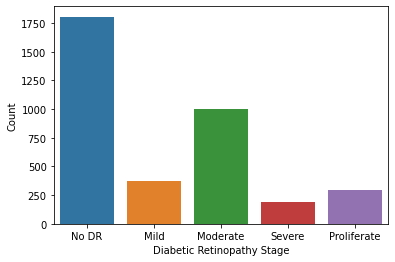

In [7]:
plt.ylabel("Count")
plt.xlabel("Diabetic Retinopathy Stage")
sns.barplot(counts.index, counts.values)


## DATASET CLASS

In [8]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [9]:
# various transformations that are applied to the images

transforms = transforms.Compose([
    transforms.ToPILImage(mode='RGB'),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])



In [10]:
img_dir = "/home/praveen/Desktop/Projects/data/aptos2019-blindness-detection/train/"
train_data = CreateDataset(train_csv, img_dir, transforms)

In [11]:
img, label = train_data[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 2


tensor([[[-2.0837, -2.1008, -2.1008,  ..., -2.0837, -2.0837, -2.0837],
         [-2.1008, -2.1008, -2.0837,  ..., -2.1008, -2.1008, -2.0837],
         [-2.0837, -2.1008, -2.1008,  ..., -2.1008, -2.0837, -2.0837],
         ...,
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.0837,  ..., -2.1008, -2.1008, -2.0837]],

        [[-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0357, -2.0357, -2.0007,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0007, -2.0007],
         ...,
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0007,  ..., -2.0182, -2.0182, -2.0182]],

        [[-1.7522, -1.7696, -1.7696,  ..., -1.7696, -1.7522, -1.7522],
         [-1.7522, -1.7696, -1.7696,  ..., -1

In [12]:
# Visualizing a data after transformations.

import matplotlib.pyplot as plt

def show_example(img, label):
    print(label)
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


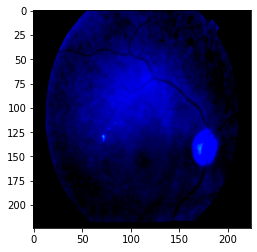

In [13]:
show_example(*train_data[5])

In [14]:
len(train_data)

3662

## Test Train Split

In [15]:
random_seed = 42
torch.manual_seed(random_seed);

In [16]:
val_size = 600
train_size = len(train_data) - val_size

train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(3062, 600)

In [17]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [18]:
# Visualising a batch of train data as a grid


from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


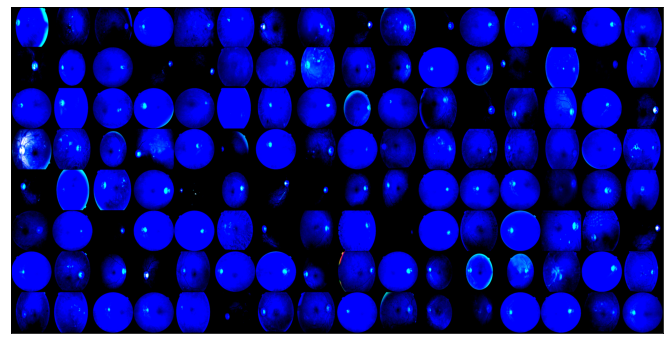

In [19]:
show_batch(train_dl)

# Model

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [46]:
# We are going to use the weights and architecture of a pretrained "Resnet34" model.

class model_Resnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [47]:
model = to_device(model_Resnet(), device)

In [27]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.678301215171814, 'val_acc': 0.09351325035095215}]

In [28]:
model.freeze()

In [29]:
epochs = 20
max_lr = 0.001
grad_clip = 1
weight_decay = 1e-6
opt_func = torch.optim.Adam

In [30]:

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.00010, train_loss: 1.3143, val_loss: 1.1943, val_acc: 0.7468



Epoch [1], last_lr: 0.00027, train_loss: 1.1176, val_loss: 1.0931, val_acc: 0.7776



Epoch [2], last_lr: 0.00051, train_loss: 1.0652, val_loss: 1.1018, val_acc: 0.7997



Epoch [3], last_lr: 0.00076, train_loss: 1.0652, val_loss: 1.2596, val_acc: 0.5829



Epoch [4], last_lr: 0.00093, train_loss: 1.0655, val_loss: 1.1106, val_acc: 0.7699



Epoch [5], last_lr: 0.00100, train_loss: 1.0936, val_loss: 1.1512, val_acc: 0.7443



Epoch [6], last_lr: 0.00099, train_loss: 1.0676, val_loss: 1.0984, val_acc: 0.7597



Epoch [7], last_lr: 0.00095, train_loss: 1.0559, val_loss: 1.1318, val_acc: 0.7373



Epoch [8], last_lr: 0.00089, train_loss: 1.0452, val_loss: 1.1192, val_acc: 0.7560



Epoch [9], last_lr: 0.00081, train_loss: 1.0382, val_loss: 1.0712, val_acc: 0.7940



Epoch [10], last_lr: 0.00072, train_loss: 1.0196, val_loss: 1.0784, val_acc: 0.7984



Epoch [11], last_lr: 0.00061, train_loss: 1.0108, val_loss: 1.0734, val_acc: 0.8125



Epoch [12], last_lr: 0.00050, train_loss: 0.9945, val_loss: 1.0457, val_acc: 0.8279



Epoch [13], last_lr: 0.00039, train_loss: 0.9814, val_loss: 1.0639, val_acc: 0.8150



Epoch [14], last_lr: 0.00028, train_loss: 0.9712, val_loss: 1.0517, val_acc: 0.8319



Epoch [15], last_lr: 0.00019, train_loss: 0.9633, val_loss: 1.0554, val_acc: 0.8317



Epoch [16], last_lr: 0.00011, train_loss: 0.9545, val_loss: 1.0526, val_acc: 0.8343



Epoch [17], last_lr: 0.00005, train_loss: 0.9476, val_loss: 1.0497, val_acc: 0.8496



Epoch [18], last_lr: 0.00001, train_loss: 0.9457, val_loss: 1.0453, val_acc: 0.8509



Epoch [19], last_lr: 0.00000, train_loss: 0.9422, val_loss: 1.0404, val_acc: 0.8574


In [31]:
model.unfreeze()

In [32]:

history += fit_one_cycle(epochs, 0.0001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay,
                         opt_func=opt_func)


Epoch [0], last_lr: 0.00001, train_loss: 0.9393, val_loss: 1.0493, val_acc: 0.8421



Epoch [1], last_lr: 0.00003, train_loss: 0.9406, val_loss: 1.0506, val_acc: 0.8484



Epoch [2], last_lr: 0.00005, train_loss: 0.9414, val_loss: 1.0472, val_acc: 0.8485



Epoch [3], last_lr: 0.00008, train_loss: 0.9385, val_loss: 1.0510, val_acc: 0.8442



Epoch [4], last_lr: 0.00009, train_loss: 0.9371, val_loss: 1.0509, val_acc: 0.8549



Epoch [5], last_lr: 0.00010, train_loss: 0.9378, val_loss: 1.0574, val_acc: 0.8357



Epoch [6], last_lr: 0.00010, train_loss: 0.9370, val_loss: 1.0712, val_acc: 0.8239



Epoch [7], last_lr: 0.00010, train_loss: 0.9352, val_loss: 1.0684, val_acc: 0.8203



Epoch [8], last_lr: 0.00009, train_loss: 0.9360, val_loss: 1.0541, val_acc: 0.8420



Epoch [9], last_lr: 0.00008, train_loss: 0.9344, val_loss: 1.0520, val_acc: 0.8342



Epoch [10], last_lr: 0.00007, train_loss: 0.9298, val_loss: 1.0540, val_acc: 0.8443



Epoch [11], last_lr: 0.00006, train_loss: 0.9301, val_loss: 1.0656, val_acc: 0.8240



Epoch [12], last_lr: 0.00005, train_loss: 0.9294, val_loss: 1.0492, val_acc: 0.8481



Epoch [13], last_lr: 0.00004, train_loss: 0.9291, val_loss: 1.0590, val_acc: 0.8304



Epoch [14], last_lr: 0.00003, train_loss: 0.9270, val_loss: 1.0609, val_acc: 0.8356



Epoch [15], last_lr: 0.00002, train_loss: 0.9258, val_loss: 1.0611, val_acc: 0.8253



Epoch [16], last_lr: 0.00001, train_loss: 0.9284, val_loss: 1.0525, val_acc: 0.8368



Epoch [17], last_lr: 0.00000, train_loss: 0.9257, val_loss: 1.0549, val_acc: 0.8393



Epoch [18], last_lr: 0.00000, train_loss: 0.9254, val_loss: 1.0614, val_acc: 0.8343



Epoch [19], last_lr: 0.00000, train_loss: 0.9255, val_loss: 1.0678, val_acc: 0.8240


## ACCURACY

In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

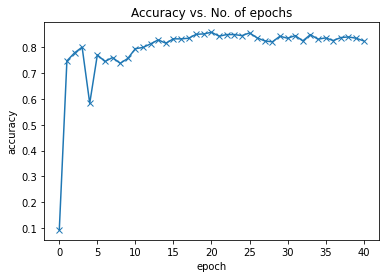

In [34]:
plot_accuracies(history)

## LOSS

In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

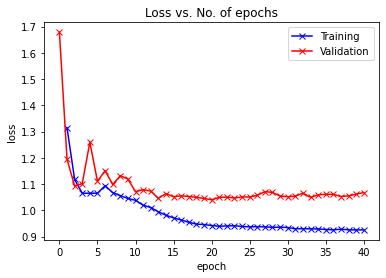

In [36]:
plot_losses(history)

In [37]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

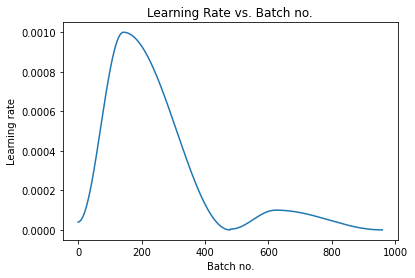

In [38]:
plot_lrs(history)

## Saving the model

In [45]:
# Save the model checkpoints 
torch.save(model.state_dict(), '/home/praveen/Desktop/Projects/diabetic_retinopathy/retinopathy.ckpt')


In [48]:
import jovian

<IPython.core.display.Javascript object>

In [49]:
jovian.commit(project='diabetic-retinopathy')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "praveenr2998/diabetic-retinopathy" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/praveenr2998/diabetic-retinopathy


'https://jovian.ml/praveenr2998/diabetic-retinopathy'